# X-Pert for Drug Perturbation Prediction

This notebook is adapted from the gene perturbation workflow for **drug perturbation** analysis. It:
- adapts perturbation format to handle drug names and dosages
- loads drug embeddings (GROVER, RDKit, ECFP, etc.) instead of gene embeddings
- incorporates dosage information into the model
- maintains the same clean structure and organization



## 1. Imports



In [1]:
# Core
import os, json, time, copy, warnings
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# X-Pert package
import xpert
from xpert.models import TransformerGenerator
from xpert.loss import masked_relative_error, masked_mse_loss, masked_huber_loss
from xpert.external_model.scgpt.gene_tokenizer import GeneVocab
from xpert.external_model.gears.inference import compute_metrics
# from xpert.data import Byte_Pert_Data

# Utils
from xpert.utils import fix_seed, merge_plot
from xpert.external_model.scgpt.util import set_seed, map_raw_id_to_vocab_id, add_file_handler



## 2. Global Settings and Logger



In [2]:
# Reproducibility
set_seed(42)
fix_seed(2024)

# Logger to file
save_root = Path("./L1000_phase1/model_mode_scFlamingo_drug_v1")
save_root.mkdir(parents=True, exist_ok=True)
logger = xpert.logger
add_file_handler(logger, save_root / "run.log")
logger.info(f"Running on {time.strftime('%Y-%m-%d %H:%M:%S')}")

# Plot default
plt.rcdefaults()
warnings.filterwarnings("ignore")



INFO:xpert:Running on 2025-11-01 17:32:36


## 3. Data Configuration



In [3]:
# Dataset and split
prefix = 'L1000_phase1'  # or 'sciplex_3', etc.
add_control = False

# Data split column (for drug perturbation datasets)
# data_split_0: random split perts
# data_split_1: split drugs
# data_split_2: split cell types
split_col = 'data_split_1'

# Paths
# Drug perturbation data path
data_dir = Path('../../data') / prefix
pert_data_version = 'pert_data.pkl'

# Drug embedding directory
drug_embed_dir = data_dir

# scGPT pretrained model
load_model_dir = Path('../../data/scGPT_human')
model_config_file = load_model_dir / 'args.json'
model_file = load_model_dir / 'best_model.pt'
vocab_file = load_model_dir / 'vocab.json'



## 4. Model Hyperparameters



Note: For drug perturbation, we typically use fewer layers (nlayers = 4-12) depending on computational resources. Adjust `device_ids` based on available GPUs.



In [4]:
# Training hyperparameters
batch_size = 64
eval_batch_size = 64
log_interval = 100

# Cell encoder hyperparameters
embsize = 512
d_hid = 512
nlayers = 2  # Can reduce to 2 for faster training
nhead = 8
n_layers_cls = 3
dropout = 0.2
use_fast_transformer = True
amp = True
device_ids = [0, 1, 2, 3]  # Adjust based on available GPUs

# Drug embedding settings
drug_embed_mode = 'ecfp'  # Options: 'grover', 'rdkit', 'morgan', 'ecfp', 'chemberta_st', 'grover+rdkit'
# Embedding dimension depends on the embedding method (will be loaded dynamically)
gpt_emb_dim = None  # Will be set after loading embeddings

# add-token settings
load_encoder_plus = True  # copy encoder weights to encoder_plus when adding tokens
include_zero_gene = "all"

# Task settings
# X-Pert settings for DRUG perturbation
pert_mode = 'drug'  # Changed from 'gene'
drug_embed_mode = drug_embed_mode  # Set above
pert_flag_mode = True  # Use drug-gene interaction matrix when True
delta_mode = False
attn_gate_mode = True
load_cxg_weight = True
mask_mode = True
use_scgpt_layer = True
use_scgpt_input = True
add_token = True
init_mode = False
cross_mode = True

# Dosage settings
dosage_mode = True  # Enable dosage information
dosage_mode_type = 1  # 0: direct multiply; 1: learnable vector; 2: additive with learnable

# Scheduler
epochs = 2
lr = 1e-4
scheduler_type = 'cosine_warm'  # or 'steplr', 'cosine'
schedule_interval = 5  # for steplr

# Gradient clipping
max_norm = 1.0



## 5. Helper Losses and Training/Eval Routines

In [5]:
# LR scheduler (cosine with warmup)
from torch.optim.lr_scheduler import LambdaLR
import math

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = (current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return LambdaLR(optimizer, lr_lambda)

# Training / Evaluation routines for DRUG perturbation
def train(model: nn.Module, train_loader: torch.utils.data.DataLoader) -> None:
    model.train()
    total_loss, total_mse = 0.0, 0.0
    start_time = time.time()
    num_batches = len(train_loader)

    for batch, batch_data in enumerate(tqdm(train_loader)):
        batch_size = len(batch_data.y)
        batch_data.to(device)
        x: torch.Tensor = batch_data.x
        ori_gene_values = x
        # Handle pert_flags for drug mode
        if pert_mode == 'drug' and pert_flag_mode:
            pert_flags = batch_data.pert_flags
        else:
            pert_flags = batch_data.pert_flags.long()
        target_gene_values = batch_data.y

        # Prepare drug perturbation embeddings and dosages
        # Format: "drug1; drug2 | dosage1; dosage2"
        batch_perts = batch_data.pert
        batch_perts = [i.split(' | ')[0].split("; ") for i in batch_perts]
        # Extract dosages and apply log10 transform
        batch_dosages = [[np.log10(float(j)+1) for j in i.split(' | ')[1].split("; ")] 
                        for i in batch_data.pert]
        
        max_pert_len = max([len(perts) for perts in batch_perts])
        batch_pert_embed = torch.zeros(batch_size, max_pert_len, gpt_emb_dim).float()
        pert_mask = torch.ones(batch_size, max_pert_len)
        batch_dosages_pad = torch.zeros(batch_size, max_pert_len).float()
        
        for i, perts in enumerate(batch_perts):
            for j, pert in enumerate(perts):
                batch_pert_embed[i, j, :] = torch.tensor(np.array(pert_embed_dict[pert]))
                pert_mask[i, j] = 0
                batch_dosages_pad[i, j] = batch_dosages[i][j]
        batch_pert_embed = batch_pert_embed.to(device)
        batch_dosages_pad = batch_dosages_pad.to(device)
        
        # Set to None if dosage_mode is False
        if not dosage_mode:
            batch_dosages_pad = None

        # Select input genes
        if include_zero_gene in ["all", "batch-wise"]:
            if include_zero_gene == "all":
                input_gene_ids = torch.arange(n_genes, device=device, dtype=torch.long)
            else:
                input_gene_ids = (
                    ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]
                )
            if len(input_gene_ids) > max_seq_len:
                input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]
            input_values = ori_gene_values[:, input_gene_ids]
            input_pert_flags = pert_flags[:, input_gene_ids]
            target_values = target_gene_values[:, input_gene_ids]
            if delta_mode:
                target_values = target_values - input_values
            mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
            mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)
            src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=device)

        with torch.cuda.amp.autocast(enabled=amp):
            output_dict = model(
                mapped_input_gene_ids,
                input_values,
                input_pert_flags,
                src_key_padding_mask=src_key_padding_mask,
                batch_pert_embed=batch_pert_embed,
                pert_mask=pert_mask,
                batch_dosages_pad=batch_dosages_pad,  # Now includes dosage information
            )
            output_values = output_dict["mlm_output"]
            masked_positions = torch.ones_like(input_values, dtype=torch.bool)
            loss = loss_mse = criterion(output_values, target_values, masked_positions)

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm, error_if_nonfinite=False if scaler.is_enabled() else True)
        scaler.step(optimizer)
        scaler.update()
        if scheduler_type in ['cosine', 'cosine_warm']:
            scheduler.step()

        total_loss += loss.item()
        total_mse += loss_mse.item()
        if batch % log_interval == 0 and batch > 0:
            lr_ = scheduler.get_last_lr()[0] if scheduler_type != 'steplr' else scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            logger.info(f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | lr {lr_:07.6f} | ms/batch {ms_per_batch:5.2f} | loss {cur_loss:5.5f} | mse {cur_mse:5.5f} |")
            total_loss = 0
            total_mse = 0
            start_time = time.time()

@torch.no_grad()
def evaluate(model: nn.Module, val_loader: torch.utils.data.DataLoader):
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    for batch, batch_data in enumerate(val_loader):
        batch_size = len(batch_data.y)
        batch_data.to(device)
        x: torch.Tensor = batch_data.x
        ori_gene_values = x
        if pert_mode == 'drug' and pert_flag_mode:
            pert_flags = batch_data.pert_flags
        else:
            pert_flags = batch_data.pert_flags.long()
        target_gene_values = batch_data.y

        batch_perts = batch_data.pert
        batch_perts = [i.split(' | ')[0].split("; ") for i in batch_perts]
        batch_dosages = [[np.log10(float(j)+1) for j in i.split(' | ')[1].split("; ")] 
                        for i in batch_data.pert]
        max_pert_len = max([len(perts) for perts in batch_perts])
        batch_pert_embed = torch.zeros(batch_size, max_pert_len, gpt_emb_dim).float()
        pert_mask = torch.ones(batch_size, max_pert_len)
        batch_dosages_pad = torch.zeros(batch_size, max_pert_len).float()
        for i, perts in enumerate(batch_perts):
            for j, pert in enumerate(perts):
                batch_pert_embed[i, j, :] = torch.tensor(np.array(pert_embed_dict[pert]))
                pert_mask[i, j] = 0
                batch_dosages_pad[i, j] = batch_dosages[i][j]
        batch_pert_embed = batch_pert_embed.to(device)
        batch_dosages_pad = batch_dosages_pad.to(device)
        if not dosage_mode:
            batch_dosages_pad = None

        if include_zero_gene in ["all", "batch-wise"]:
            if include_zero_gene == "all":
                input_gene_ids = torch.arange(n_genes, device=device)
            else:
                input_gene_ids = (
                    ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]
                )
            if len(input_gene_ids) > max_seq_len:
                input_gene_ids = torch.randperm(len(input_gene_ids), device=device)[:max_seq_len]
            input_values = ori_gene_values[:, input_gene_ids]
            input_pert_flags = pert_flags[:, input_gene_ids]
            target_values = target_gene_values[:, input_gene_ids]
            if delta_mode:
                target_values = target_values - input_values
            mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
            mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)
            src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=input_values.device)

        with torch.cuda.amp.autocast(enabled=amp):
            output_dict = model(
                mapped_input_gene_ids,
                input_values,
                input_pert_flags,
                src_key_padding_mask=src_key_padding_mask,
                batch_pert_embed=batch_pert_embed,
                pert_mask=pert_mask,
                batch_dosages_pad=batch_dosages_pad,
            )
            output_values = output_dict["mlm_output"]
            masked_positions = torch.ones_like(input_values, dtype=torch.bool, device=input_values.device)
            loss = criterion(output_values, target_values, masked_positions)
        total_loss += loss.item()
        total_error += masked_relative_error(output_values, target_values, masked_positions).item()
    return total_loss / len(val_loader), total_error / len(val_loader)

@torch.no_grad()
def pred_perturb_new(model, batch_data, include_zero_gene="batch-wise", gene_ids=None, amp=True):
    model.eval()
    device = next(model.parameters()).device
    batch_data.to(device)
    batch_size = len(batch_data.pert)
    x: torch.Tensor = batch_data.x
    ori_gene_values = x
    if pert_mode == 'drug' and pert_flag_mode:
        pert_flags = batch_data.pert_flags
    else:
        pert_flags = batch_data.pert_flags.long()

    batch_perts = batch_data.pert
    batch_perts = [i.split(' | ')[0].split("; ") for i in batch_perts]
    batch_dosages = [[np.log10(float(j)+1) for j in i.split(' | ')[1].split("; ")] 
                    for i in batch_data.pert]
    max_pert_len = max([len(perts) for perts in batch_perts])
    batch_pert_embed = torch.zeros(batch_size, max_pert_len, gpt_emb_dim).float()
    pert_mask = torch.ones(batch_size, max_pert_len)
    batch_dosages_pad = torch.zeros(batch_size, max_pert_len).float()
    for i, perts in enumerate(batch_perts):
        for j, pert in enumerate(perts):
            batch_pert_embed[i, j, :] = torch.tensor(np.array(pert_embed_dict[pert]))
            pert_mask[i, j] = 0
            batch_dosages_pad[i, j] = batch_dosages[i][j]
    batch_pert_embed = batch_pert_embed.to(device)
    batch_dosages_pad = batch_dosages_pad.to(device)
    if not dosage_mode:
        batch_dosages_pad = None

    if include_zero_gene in ["all", "batch-wise"]:
        assert gene_ids is not None
        if include_zero_gene == "all":
            input_gene_ids = torch.arange(ori_gene_values.size(1), device=device)
        else:
            input_gene_ids = (
                ori_gene_values.nonzero()[:, 1].flatten().unique().sort()[0]
            )
        input_values = ori_gene_values[:, input_gene_ids]
        input_pert_flags = pert_flags[:, input_gene_ids]
        mapped_input_gene_ids = map_raw_id_to_vocab_id(input_gene_ids, gene_ids)
        mapped_input_gene_ids = mapped_input_gene_ids.repeat(batch_size, 1)
        src_key_padding_mask = torch.zeros_like(input_values, dtype=torch.bool, device=device)
        with torch.cuda.amp.autocast(enabled=amp):
            output_dict = model(
                mapped_input_gene_ids,
                input_values,
                input_pert_flags,
                src_key_padding_mask=src_key_padding_mask,
                batch_pert_embed=batch_pert_embed,
                pert_mask=pert_mask,
                batch_dosages_pad=batch_dosages_pad,
            )
        output_values = output_dict["mlm_output"].float()
        pred_gene_values = torch.zeros_like(ori_gene_values)
        pred_gene_values[:, input_gene_ids] = output_values
        if delta_mode:
            pred_gene_values = input_values + pred_gene_values
    return pred_gene_values



In [6]:
def eval_perturb_new(
    loader,
    model,
    device: torch.device,
):
    """
    Run model in inference mode using a given data loader.
    Returns a dict with predictions on all genes and DE gene subsets.
    """
    model.eval()
    model.to(device)

    pert_cat = []
    pred = []
    truth = []
    pred_de = []
    truth_de = []
    results = {}

    for itr, batch in enumerate(loader):
        batch.to(device)
        pert_cat.extend(batch.pert)

        with torch.no_grad():
            p = pred_perturb_new(model, batch, include_zero_gene, gene_ids=gene_ids)
            t = batch.y
            pred.extend(p.cpu())
            truth.extend(t.cpu())

            # Differentially expressed genes
            for bidx, de_idx in enumerate(batch.de_idx):
                pred_de.append(p[bidx, de_idx])
                truth_de.append(t[bidx, de_idx])

    # all genes
    results["pert_cat"] = np.array(pert_cat)
    pred = torch.stack(pred)
    truth = torch.stack(truth)
    results["pred"] = pred.detach().cpu().numpy().astype(np.float64)
    results["truth"] = truth.detach().cpu().numpy().astype(np.float64)

    # DE genes
    pred_de = torch.stack(pred_de)
    truth_de = torch.stack(truth_de)
    results["pred_de"] = pred_de.detach().cpu().numpy().astype(np.float64)
    results["truth_de"] = truth_de.detach().cpu().numpy().astype(np.float64)

    return results



## 6. Data Loading and Tokenization



In [ ]:
# Build dataset via Byte_Pert_Data
seed = 2024
bs_train = 32
bs_test = bs_train * 2

# Load preprocessed pert_data object
import pickle
pert_data = pickle.load(open(data_dir / pert_data_version, 'rb'))
# pert_data = pickle.load(open("/nfs/public/lichen/results/single_cell_perturbation/perturbation_drug/data/L1000_phase1/pert_data_v1.pkl", 'rb'))

# Set var_genes
pert_data.var_genes = pert_data.adata_split.var_names

# Build X-Pert training datasets
# Note: get_Data_scgpt needs to be adapted for drug format with split_col
pert_data.get_Data_scgpt_2(
    num_de_genes=pert_data.num_de_genes,
    dataset_name=['train', 'test', 'val'],
    add_control=add_control,
    split_col=split_col,  # Drug datasets use specific split columns
    pert_flag_mode=pert_flag_mode,  # For drug-gene interaction matrix
    drug_embed_dir=drug_embed_dir,
)


100%|██████████| 26950/26950 [02:32<00:00, 176.48it/s]
0it [00:00, ?it/s]


========== get Data_scGPT finished!


In [8]:

# Set adata
pert_data.adata = pert_data.adata_split
pert_data.adata.var["gene_name"] = pert_data.adata.var_names

# DataLoaders
trainloader, testloader, valloader = pert_data.get_dataloader(
    mode='all', 
    bs_train=int(bs_train)*len(device_ids), 
    bs_test=int(bs_test)*len(device_ids)
)



In [9]:
len(trainloader), len(testloader), len(valloader)

(4029, 530, 0)

In [10]:
len(pert_data.dataloader["train_loader"]), len(pert_data.dataloader["val_loader"]), len(pert_data.dataloader["test_loader"])

(4029, 530, 530)

## 7. Drug Embeddings and Vocabulary



In [11]:
# Load drug embeddings based on drug_embed_mode
if drug_embed_mode == 'grover':
    pert_embed = pd.read_csv(drug_embed_dir / 'embed_grover.csv', sep=',', index_col=0)
elif drug_embed_mode == 'rdkit':
    pert_embed = pd.read_csv(drug_embed_dir / 'embed_rdkit.csv', sep=',', index_col=0)
elif drug_embed_mode == 'morgan':
    pert_embed = pd.read_csv(drug_embed_dir / 'embed_morgan.csv', sep=',', index_col=0)
elif drug_embed_mode == 'ecfp':
    pert_embed = pd.read_csv(drug_embed_dir / 'embed_ecfp.csv', sep=',', index_col=0)
elif drug_embed_mode == 'chemberta_st':
    pert_embed = pd.read_csv(drug_embed_dir / 'embed_chemberta_st.csv', sep=',', index_col=0)
elif drug_embed_mode == 'grover+rdkit':
    pert_embed_1 = pd.read_csv(drug_embed_dir / 'embed_grover.csv', sep=',', index_col=0)
    pert_embed_2 = pd.read_csv(drug_embed_dir / 'embed_rdkit.csv', sep=',', index_col=0)
    pert_embed = pd.concat([pert_embed_1, pert_embed_2], axis=0)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    pert_embed = pd.DataFrame(
        scaler.fit_transform(pert_embed.T).T, 
        index=pert_embed.index, 
        columns=pert_embed.columns
    )
else:
    raise ValueError(f"Unknown drug_embed_mode: {drug_embed_mode}")

# Set embedding dimension
gpt_emb_dim = pert_embed.shape[0]

# Collect all drug names (from perturbation_group format: "drug1; drug2 | dosage1; dosage2")
total_perts = [i.split(' | ')[0] for i in pert_data.filter_perturbation_list]
# Split multi-drug perturbations
all_drugs = []
for pert_str in total_perts:
    all_drugs.extend(pert_str.split('; '))
total_perts = np.unique(all_drugs)

# Create pert_embed_dict
pert_embed_dict: Dict[str, np.ndarray] = {}
np.random.seed(2024)
for pert in total_perts:
    if pert in pert_embed.columns:
        pert_embed_dict[pert] = pert_embed.loc[:, pert].values
    else:
        logger.warning(f'{pert} not in pert_embed, using random embedding')
        pert_embed_dict[pert] = pert_embed.loc[:, np.random.choice(pert_embed.columns, 1)[0]].values

logger.info(f"Loaded {len(pert_embed_dict)} drug embeddings with dimension {gpt_emb_dim}")

# Load vocab and extend if needed
vocab = GeneVocab.from_file(vocab_file)
special_tokens = ["<pad>", "<cls>", "<eoc>"]
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)
        
vocab_ori = copy.deepcopy(vocab)
if add_token:
    # add non-overlap genes to the vocab
    add_genes = np.setdiff1d(pert_data.adata.var_names, list(vocab.get_stoi().keys()))
    for gene in add_genes:
        if gene not in vocab:
            vocab.append_token(gene)

# Mark genes present in vocab
pert_data.adata.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in pert_data.adata.var_names]
gene_ids_in_vocab = np.array(pert_data.adata.var["id_in_vocab"])
logger.info(f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes in vocabulary of size {len(vocab)}.")

# Build token ids for input genes
genes = pert_data.adata.var["gene_name"].tolist()
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array([vocab[g] if g in vocab else vocab["<pad>"] for g in genes], dtype=int)
n_genes = len(genes)

# Sequence length
max_seq_len = 6000



INFO:xpert:Loaded 17200 drug embeddings with dimension 2048
INFO:xpert:match 978/978 genes in vocabulary of size 60726.


## 8. Build Model, Optimizer and Scheduler



In [12]:
# Load model config
with open(model_config_file, 'r') as f:
    model_configs = json.load(f)
embsize = model_configs.get('embsize', embsize)
d_hid = model_configs.get('d_hid', d_hid)
n_layers_cls = model_configs.get('n_layers_cls', n_layers_cls)

# Token count
ntokens = len(vocab_ori)  # using extended vocab if add_token True

# Model
model = TransformerGenerator(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=n_layers_cls,
    n_cls=1,
    vocab=vocab,
    dropout=dropout,
    pad_token='<pad>',
    pad_value=0,
    pert_pad_id=2,
    use_fast_transformer=use_fast_transformer,
    pert_embed_dict=pert_embed_dict,
    gpt_emb_dim=gpt_emb_dim,
    model_mode='scFlamingo_drug_v1',  # or specify your model mode
    attn_gate_mode=attn_gate_mode,
    pert_mode=pert_mode,
    drug_embed_mode=drug_embed_mode,
    pert_flag_mode=pert_flag_mode,
    use_scgpt_layer=use_scgpt_layer,
    use_scgpt_input=use_scgpt_input,
    mask_mode=mask_mode,
    add_token=add_token,
    init_mode=init_mode,
    dosage_mode_type=dosage_mode_type,
    cross_mode=cross_mode,
)

# Optionally load pretrained partial weights
if load_cxg_weight:
    load_param_prefixs = ["encoder", "value_encoder", "transformer_encoder"]
    state = torch.load(model_file)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in state.items() if any([k.startswith(p) for p in load_param_prefixs])}
    model_dict.update(pretrained_dict)
    missing = model.load_state_dict(model_dict, strict=False)
    logger.info(f"Missing keys: {len(missing.missing_keys)}")
    logger.info(f"Unexpected keys: {len(missing.unexpected_keys)}")

# If adding tokens, optionally load encoder weights into encoder_plus and init new tokens
if add_token and load_encoder_plus:
    with torch.no_grad():
        n = model.encoder.embedding.num_embeddings
        # copy base encoder weights and norms
        model.encoder_plus.embedding.weight[:n] = model.encoder.embedding.weight
        model.encoder_plus.enc_norm.weight[:] = model.encoder.enc_norm.weight
        model.encoder_plus.enc_norm.bias[:] = model.encoder.enc_norm.bias
        # initialize newly added tokens with mean/std of pretrained embeddings
        pretrained_embed = model.encoder.embedding.weight  # (n, d)
        mean = pretrained_embed.mean(dim=0)
        std = pretrained_embed.std(dim=0)
        m = model.encoder_plus.embedding.num_embeddings - n
        if m > 0:
            model.encoder_plus.embedding.weight[n:] = torch.normal(
                mean=mean.expand(m, -1),
                std=std.expand(m, -1)
            )

# Device & DP
device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    try:
        device_ids  # use pre-defined list if exists
    except NameError:
        device_ids = list(range(torch.cuda.device_count()))
    model = torch.nn.DataParallel(model, device_ids=device_ids).to(device)
else:
    model = model.to(device)

# Loss, optimizer, scheduler
loss_type = 'mse'
criterion = masked_mse_loss if loss_type == 'mse' else masked_huber_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
if scheduler_type == 'steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, schedule_interval, gamma=0.9)
elif scheduler_type == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(trainloader)*epochs)
elif scheduler_type == 'cosine_warm':
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(len(trainloader)*epochs*0.05),
        num_training_steps=len(trainloader)*epochs,
    )
else:
    raise ValueError('Unknown scheduler')

scaler = torch.cuda.amp.GradScaler(enabled=amp)



Using simple batchnorm instead of domain specific batchnorm


INFO:xpert:Missing keys: 0
INFO:xpert:Unexpected keys: 120


## 9. Training Loop and Validation

In [13]:
# Training loop
best_val_loss = float('inf')
best_model = None
patience = 0
early_stop = epochs

train_metrics_list, train_metrics_pert_list = [], []
val_metrics_list, val_metrics_pert_list = [], []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loader = pert_data.dataloader["train_loader"]
    valid_loader = pert_data.dataloader["val_loader"]

    train(model, train_loader)
    val_loss, val_mre = evaluate(model, valid_loader)
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | valid loss/mse {val_loss:5.4f} |")
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        logger.info(f"Best model with score {best_val_loss:5.4f}")
        patience = 0
        torch.save(best_model.state_dict(), save_root / "model_best.pt")
    else:
        patience += 1
        if patience >= early_stop:
            logger.info(f"Early stop at epoch {epoch}")
            break

    # Check for NaN loss
    if np.isnan(val_loss):
        logger.warning(f"NaN loss detected at epoch {epoch}, stopping training")
        break

    # Collect metrics for plotting later (optional, can be expensive)
    train_res = eval_perturb_new(train_loader, model, device)
    val_res = eval_perturb_new(valid_loader, model, device)
    if train_res is not None:
        train_metrics, train_metrics_pert = compute_metrics(train_res)
        train_metrics_list.append(train_metrics)
        train_metrics_pert_list.append(train_metrics_pert)
    if val_res is not None:
        val_metrics, val_metrics_pert = compute_metrics(val_res)
        val_metrics_list.append(val_metrics)
        val_metrics_pert_list.append(val_metrics_pert)

    if scheduler_type == 'steplr':
        scheduler.step()



100%|██████████| 4029/4029 [08:58<00:00,  7.49it/s]
INFO:xpert:-----------------------------------------------------------------------------------------
INFO:xpert:| end of epoch   1 | time: 580.58s | valid loss/mse 1.2698 |
INFO:xpert:-----------------------------------------------------------------------------------------
INFO:xpert:Best model with score 1.2698
100%|██████████| 4029/4029 [08:55<00:00,  7.53it/s]
INFO:xpert:-----------------------------------------------------------------------------------------
INFO:xpert:| end of epoch   2 | time: 586.06s | valid loss/mse 1.2105 |
INFO:xpert:-----------------------------------------------------------------------------------------
INFO:xpert:Best model with score 1.2105


In [14]:
len(valid_loader)

530

## 10. Final Evaluation and Save Artifacts



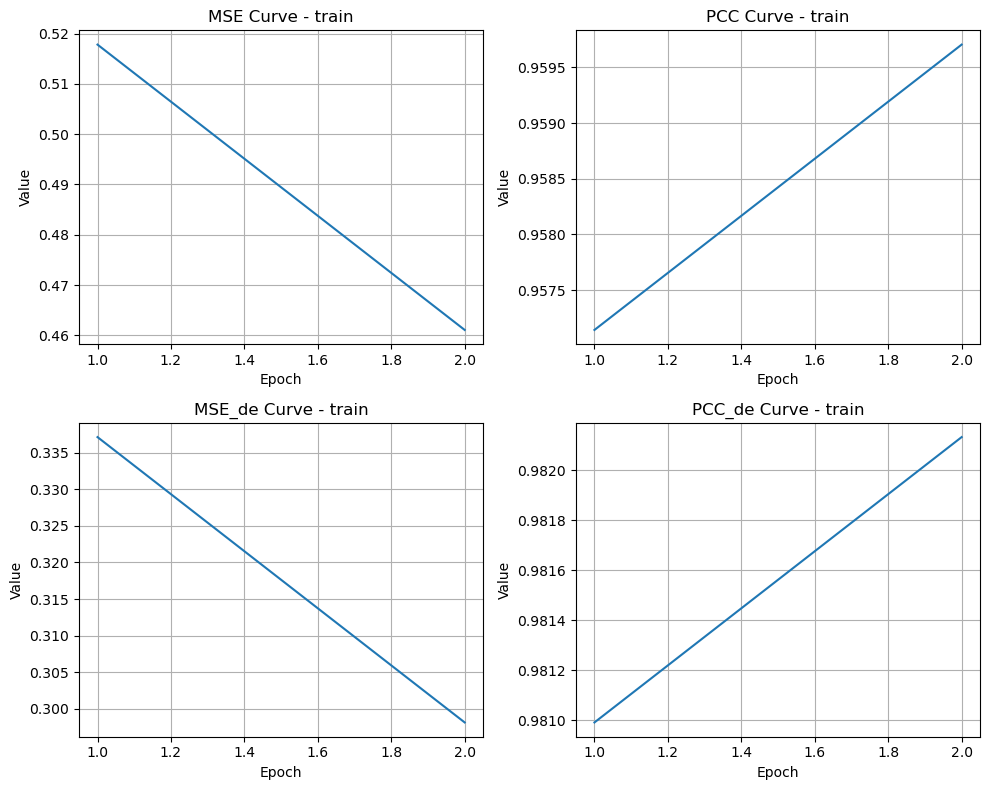

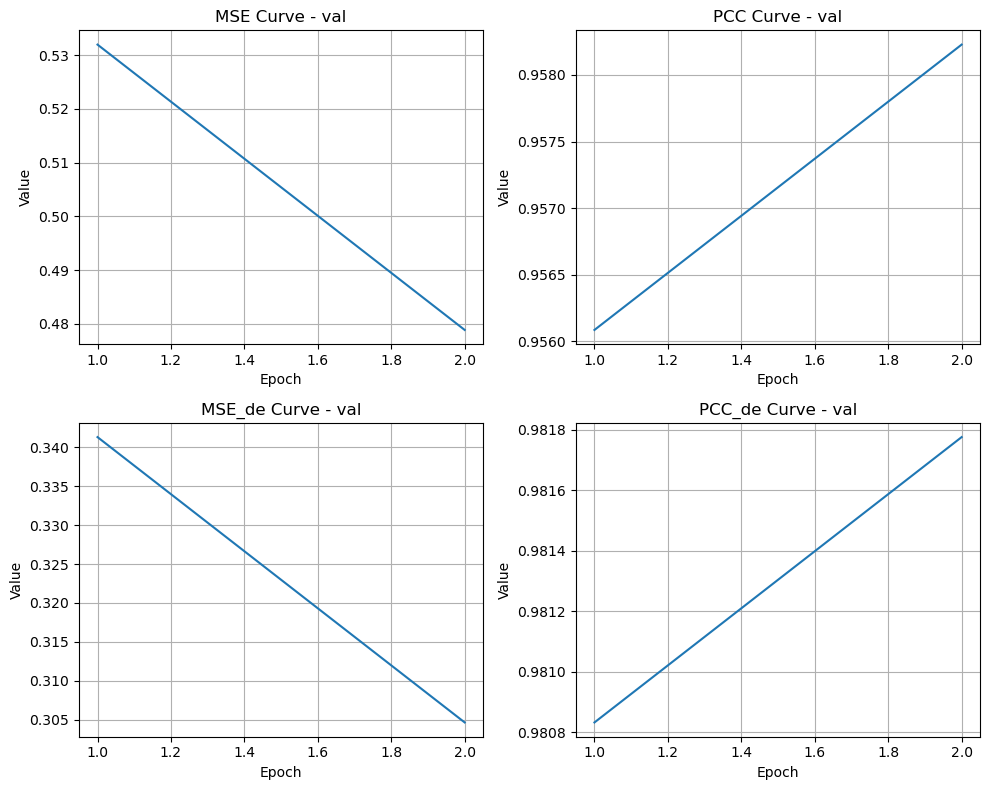

In [15]:
# Save best model and evaluate on test set
torch.save(best_model.state_dict(), save_root / "model_best.pt")

test_loader = pert_data.dataloader["test_loader"]

test_res = eval_perturb_new(test_loader, best_model, device)
# test_metrics, test_pert_res = compute_metrics(test_res)  # optional

# Save results
model_prefix = f'lr_{lr}_dosage_{dosage_mode_type}'
result_dir = save_root / f'result_{model_prefix}'
result_dir.mkdir(parents=True, exist_ok=True)

import pickle
pickle.dump(test_res, open(result_dir / 'test_res.pkl', 'wb'))
if len(train_metrics_list) > 0:
    pickle.dump(train_metrics_list, open(result_dir / 'train_metrics_list.pkl', 'wb'))
    pickle.dump(train_metrics_pert_list, open(result_dir / 'train_metrics_pert_list.pkl', 'wb'))
    pickle.dump(val_metrics_list, open(result_dir / 'val_metrics_list.pkl', 'wb'))
    pickle.dump(val_metrics_pert_list, open(result_dir / 'val_metrics_pert_list.pkl', 'wb'))

# Optional plotting if metrics were collected
if len(train_metrics_list) > 0:
    try:
        merge_plot(train_metrics_list, 'train', str(result_dir / 'train.png'))
        merge_plot(val_metrics_list, 'val', str(result_dir / 'val.png'))
    except Exception as e:
        logger.warning(f"Plotting skipped: {e}")

# Free CUDA cache
torch.cuda.empty_cache()

